# Feature Extraction and Matching using OpenCV

This notebook demonstrates how to detect and locate an object in a scene using **feature extraction and matching techniques** with OpenCV. The objective is to take a **query image** that contains an object of interest and find that object in a **larger target image** or within a **video stream**.

### What this notebook covers:

- **Feature Detection** using:
  - `SIFT (Scale-Invariant Feature Transform)` – highly accurate, scale and rotation invariant.
  
- **Feature Matching** with:
  - `FLANN-based matcher` (Fast Library for Approximate Nearest Neighbors)

- **Object Localization**:
  - Use **Homography** to estimate the geometric transformation and draw the object’s outline in the target image.

- **Bonus Task**:
  - Apply the detection pipeline on a **video**, drawing a rectangle around the detected object in real-time, while optimizing for speed (e.g., processing every few frames).

### Submitted by:
- Hager Tamer Abd El-Fattah 120210092
- Noura Moustafa Mahmoud Maklad 120210150

In [1]:
pip install opencv-python opencv-contrib-python

   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/46.2 MB 330.3 kB/s eta 0:02:20
   ---------------------------------------- 0.0/46.2 MB 330.3 kB/s eta 0:02:20
   ---------------------------------------- 0.0/46.2 MB 330.3 kB/s eta 0:02:20
   ---------------------------------------- 0.0/46.2 MB 179.6 kB/s eta 0:04:17
   ---------------------------------------- 0.1/46.2 MB 286.7 kB/s eta 0:02:41
   ---------------------------------------- 0.1/46.2 MB 276.8 kB/s eta 0:02:47
   ---------------------------------------- 0.1/46.2 MB 276.8 kB/s eta 0:02:47
   ---------------------------------------- 0.1/46.2 MB 285.2 kB/s eta 0:02:42
   ---------------------------------------- 0.1/46.2 MB 257.8 kB/s eta 0:02:59
   ---------------------------------------- 0.1/46.2 MB 275.0 kB/s eta 0:02:48


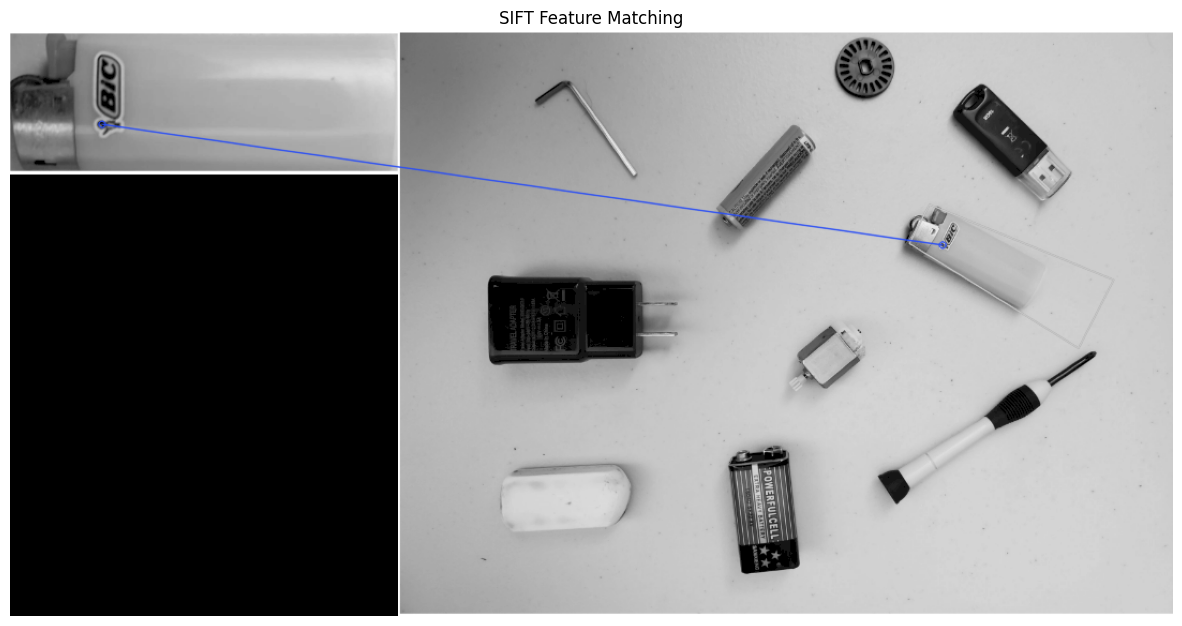

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load query and target images
query_img = cv2.imread('query.PNG', cv2.IMREAD_GRAYSCALE)
target_img = cv2.imread('target.PNG', cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
kp1, des1 = sift.detectAndCompute(query_img, None)
kp2, des2 = sift.detectAndCompute(target_img, None)

# Use FLANN based matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Draw the matches
result_img = cv2.drawMatches(query_img, kp1, target_img, kp2, good_matches, None,
                             flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Show the result
plt.figure(figsize=(15, 8))
plt.imshow(result_img)
plt.title("SIFT Feature Matching")
plt.axis('off')
plt.show()


In [3]:
import cv2
import numpy as np

cap = cv2.VideoCapture('TargetVideo.mp4')

query_img = cv2.imread('QueryImage.jpg', 0)
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(query_img, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# 👇 Initialize frame counter
frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 👇 Skip frames to improve speed
    frame_count += 1
    if frame_count % 3 != 0:
        continue  

    # Resize frame for speed (optional)
    frame = cv2.resize(frame, (0, 0), fx=0.5, fy=0.5)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    kp2, des2 = sift.detectAndCompute(gray_frame, None)

    if des2 is None:
        continue

    matches = flann.knnMatch(des1, des2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    if len(good_matches) > 10:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        h, w = query_img.shape
        pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, matrix)
        frame = cv2.polylines(frame, [np.int32(dst)], True, (0, 255, 0), 3)

    cv2.imshow("Video Object Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
